In [41]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.models import Sequential
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import cv2

In [42]:
batch_size = 32
img_height = 180
img_width = 180

In [43]:
training = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/pragn/Downloads/dataset_T2MRI',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 14 classes.
Using 500 files for training.


In [44]:
validation = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/pragn/Downloads/dataset_T2MRI',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 14 classes.
Using 124 files for validation.


In [45]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

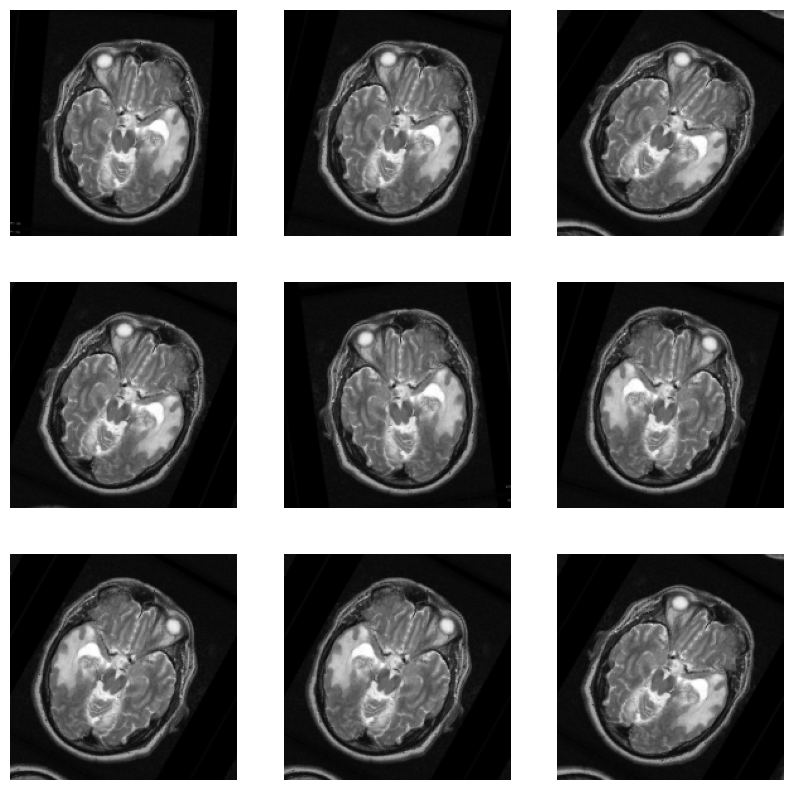

In [46]:
plt.figure(figsize=(10, 10))
for images, _ in training.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [47]:
classes = training.class_names
print(classes)

['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']


In [48]:
for image_batch, labels_batch in training:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [49]:
AUTOTUNE = tf.data.AUTOTUNE
training = training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [50]:
normlayer = layers.Rescaling(1./255)

In [51]:
normdata = training.map(lambda x, y: (normlayer(x), y))
image_batch, labels_batch = next(iter(normdata))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.022058824 1.0


In [52]:
numclass = len(classes)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(numclass)
])

In [53]:
model.layers.remove(model.layers[2])

In [54]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [56]:
epochs=20
history = model.fit(
  training,
  validation_data=validation,
  epochs=epochs)

Epoch 1/20
16/16 [==============================] - 10s 476ms/step - loss: 2.3176 - accuracy: 0.2880 - val_loss: 1.9998 - val_accuracy: 0.4113
Epoch 2/20
16/16 [==============================] - 7s 439ms/step - loss: 1.6071 - accuracy: 0.5420 - val_loss: 1.2499 - val_accuracy: 0.5806
Epoch 3/20
16/16 [==============================] - 7s 451ms/step - loss: 0.8854 - accuracy: 0.7240 - val_loss: 0.9785 - val_accuracy: 0.7339
Epoch 4/20
16/16 [==============================] - 7s 448ms/step - loss: 0.4072 - accuracy: 0.8820 - val_loss: 0.7104 - val_accuracy: 0.7823
Epoch 5/20
16/16 [==============================] - 7s 445ms/step - loss: 0.1803 - accuracy: 0.9420 - val_loss: 0.9003 - val_accuracy: 0.8387
Epoch 6/20
16/16 [==============================] - 7s 445ms/step - loss: 0.0774 - accuracy: 0.9800 - val_loss: 0.6017 - val_accuracy: 0.8710
Epoch 7/20
16/16 [==============================] - 7s 445ms/step - loss: 0.0330 - accuracy: 0.9960 - val_loss: 0.8203 - val_accuracy: 0.8548
Epoch

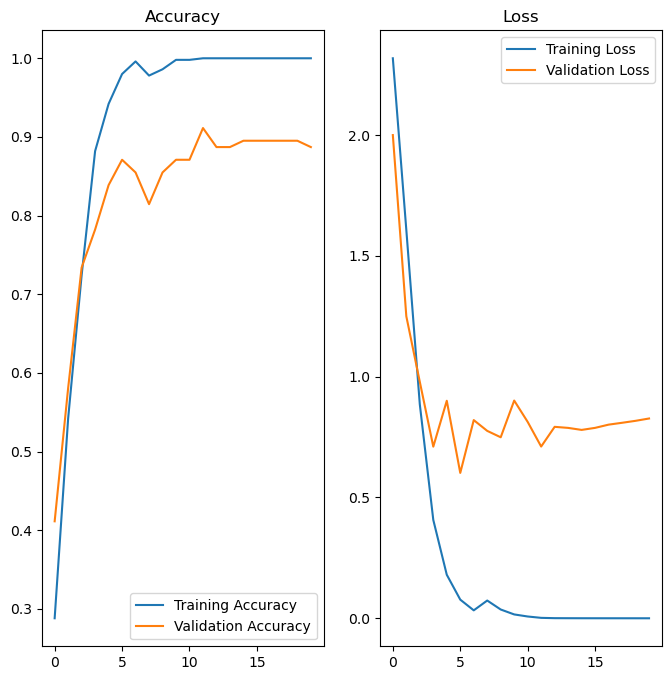

In [57]:
tacc = history.history['accuracy']
vacc = history.history['val_accuracy']

tloss = history.history['loss']
vloss = history.history['val_loss']

eprange = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(eprange, tacc, label='Training Accuracy')
plt.plot(eprange, vacc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(eprange, tloss, label='Training Loss')
plt.plot(eprange, vloss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [58]:
def prediction(datpath, model):
    img_height, img_width = 180, 180
    im = tf.keras.utils.load_img(datpath, target_size=(img_height, img_width))
    imarray = tf.keras.utils.img_to_array(im)
    imarray = tf.expand_dims(imarray, 0) 
    predict = model.predict(imarray)
    classindex = np.argmax(predict[0])
    return classindex

In [59]:
model.save('my_model.keras')
loaded_model = tf.keras.models.load_model('model.h5')

In [60]:
dat = 'C:/Users/pragn/Downloads/dataset_T2MRI/Astrocitoma/006be184fb63e8806d40bc970ff4d6_big_gallery.jpg'
mri = cv2.imread(dat)
classindex = prediction(dat, model)

1/1 [==============================] - 0s 174ms/step


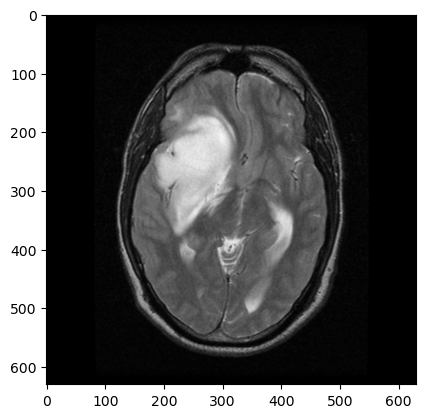

In [61]:
plt.imshow(mri)

In [62]:
seg = mri.reshape(-1, 3)
seg = np.float32(seg)

In [66]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
_,labels,centers = cv2.kmeans(seg, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
labels = labels.reshape((mri.shape[:-1]))
redu = np.uint8(centers)[labels]

In [67]:
segmentation = [np.hstack([mri, redu])]
for i, c in enumerate(centers):
    mask = cv2.inRange(labels, i, i)
    mask = np.dstack([mask]*3) 
    tumor = cv2.bitwise_and(mri, mask)

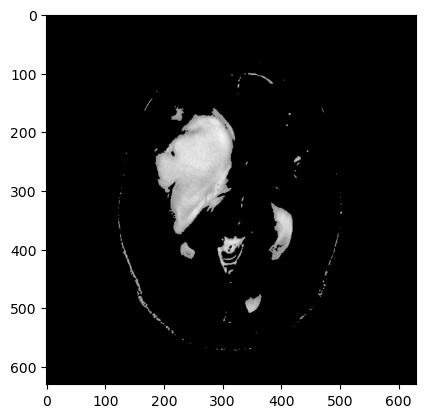

In [68]:
plt.imshow(tumor)

In [69]:
kernel = np.ones((3, 3), np.uint8)

Noise Reduction


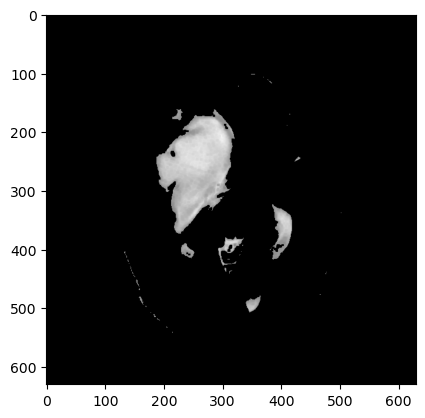

In [70]:
eroded = cv2.erode(tumor, kernel, iterations= 1)
plt.imshow(eroded)
print("Noise Reduction")

In [71]:
tum = eroded
grey = cv2.cvtColor(tum, cv2.COLOR_BGR2GRAY)
thresh = cv2.convertScaleAbs(grey)

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
anomaly = max(contours, key=cv2.contourArea)

In [72]:
cv2.drawContours(tum, [anomaly], -1, (191, 54, 12), 3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

SYSTEM SUMMARY:
-------------------------------------------
Intracranial Tumor Type: Astrocitoma


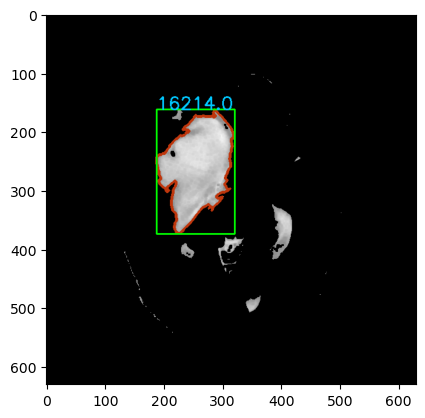

In [73]:
types = ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']
print("SYSTEM SUMMARY:")
print("-------------------------------------------")
print("Intracranial Tumor Type: "+types[classindex])

area = cv2.contourArea(anomaly)
x, y, w, h = cv2.boundingRect(anomaly) 
cv2.rectangle(tum, (x, y), (x+w, y+h), (0, 255, 0), 2) 
cv2.putText(tum, str(area), (x, y), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 200, 255), 2) 
plt.imshow(tum)